<a href="https://www.kaggle.com/code/katecaldwell/classifying-reddit-post-titles-w-rnn?scriptVersionId=96780218" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Classifying Titles with a Recurrant Neural Network

In this notebook, I use Reddit post titles, labeled with political lean (i.e. 'Conservative' or 'Liberal') to train a recurrant neural network. 

The data can be found [here](http://www.kaggle.com/datasets/neelgajare/liberals-vs-conservatives-on-reddit-13000-posts).

I referenced many materials to complete this and related notebooks, including [*Deep Learning with Python*](http://https://www.manning.com/books/deep-learning-with-python) by François Chollet and [*Natural Language Processing with Transformers*](http://https://www.oreilly.com/library/view/natural-language-processing/9781098103231/) by Lewis Tunstall, Leandro von Werra, Thomas Wolf.

In [1]:
# imports, load data, drop irrelevant columns

import numpy as np
import pandas as pd
import os

reddit_politics = pd.read_csv(
    "../input/liberals-vs-conservatives-on-reddit-13000-posts/file_name.csv")

reddit_politics = reddit_politics.drop(columns=['Score', 'Id', 'Subreddit', 'URL', 'Num of Comments', 'Text', 'Date Created'])

In [2]:
# shuffle and split data

reddit_politics = reddit_politics.sample(frac=1)

x = reddit_politics["Title"]
y = reddit_politics["Political Lean"]

ten_percent = 1285

x_train = x[2571:]
x_val = x[1285:2571]
x_test = x[:1285]

y_train = y[2571:]
y_val = y[1285:2571]
y_test = y[:1285]

In [3]:
# prepare the label data

def prepareLabelData(data):
    # convert to 0s & 1s
    return pd.get_dummies(data)['Conservative'].to_numpy()
    
    
y_train = prepareLabelData(y_train)
y_val = prepareLabelData(y_val)
y_test = prepareLabelData(y_test)

In [4]:
# prepare Title data using Keras vectorization layer and one hot encoding

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

vocab_size = 500 # maximum length of vocabulary
max_len = 100 # maximum length of title

vectorize_layer = tf.keras.layers.TextVectorization(
        max_tokens=vocab_size,
        output_mode='int',
        output_sequence_length=max_len)

vectorize_layer.adapt(x_train)

def prepareTitleData(data, vectorize_layer, vocab_size):
    data = data.to_numpy()
    data = vectorize_layer(data)
    data = tf.one_hot(data, vocab_size)
    return data

x_train = prepareTitleData(x_train, vectorize_layer, vocab_size)
x_val = prepareTitleData(x_val, vectorize_layer, vocab_size)
x_test = prepareTitleData(x_test, vectorize_layer, vocab_size)

2022-05-27 19:32:13.467813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 19:32:13.583238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 19:32:13.583984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 19:32:13.585093: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
import keras
from keras import layers
import tensorflow as tf
inputs = keras.Input(shape=(None,500), dtype="float32")
#embedded = tf.one_hot(inputs, depth=10000)
x = layers.Bidirectional(layers.LSTM(32))(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 500)]       0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                136448    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 136,513
Trainable params: 136,513
Non-trainable params: 0
_________________________________________________________________


In [6]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
history = model.fit(x_train,y_train, validation_data=(x_val, y_val), epochs=10, batch_size=16, callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(x_test, y_test)[1]:.3f}")

2022-05-27 19:32:17.645102: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2056600000 exceeds 10% of free system memory.


Epoch 1/10


2022-05-27 19:32:22.659471: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


643/643 [==============================] - 12s 12ms/step - loss: 0.6366 - accuracy: 0.6524 - val_loss: 0.6095 - val_accuracy: 0.6625
Epoch 2/10
643/643 [==============================] - 7s 10ms/step - loss: 0.5821 - accuracy: 0.7037 - val_loss: 0.5811 - val_accuracy: 0.6866
Epoch 3/10
643/643 [==============================] - 8s 12ms/step - loss: 0.5553 - accuracy: 0.7202 - val_loss: 0.5750 - val_accuracy: 0.6936
Epoch 4/10
643/643 [==============================] - 7s 10ms/step - loss: 0.5423 - accuracy: 0.7283 - val_loss: 0.5679 - val_accuracy: 0.6983
Epoch 5/10
643/643 [==============================] - 7s 11ms/step - loss: 0.5326 - accuracy: 0.7318 - val_loss: 0.5726 - val_accuracy: 0.6983
Epoch 6/10
643/643 [==============================] - 7s 11ms/step - loss: 0.5288 - accuracy: 0.7395 - val_loss: 0.5665 - val_accuracy: 0.7006
Epoch 7/10
643/643 [==============================] - 7s 11ms/step - loss: 0.5194 - accuracy: 0.7440 - val_loss: 0.5753 - val_accuracy: 0.6998
Epoch 8/1

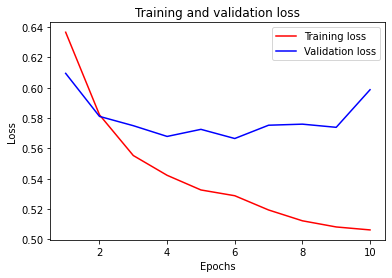

In [7]:
# plot loss over epochs

import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", label="Training loss") # "b--" is for "blue dashed line"
plt.plot(epochs, val_loss_values, "b", label="Validation loss") # b is for "solid blue line"
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [8]:
# get test metrics

from sklearn import metrics

preds = model(x_test)
preds = preds.numpy()
preds = preds>0.5

print("Accuracy is", metrics.accuracy_score(y_test, preds))
print("F1 score is", metrics.f1_score(y_test, preds))
print("Precision is", metrics.precision_score(y_test, preds))
print("Recall is", metrics.recall_score(y_test, preds))

Accuracy is 0.7198443579766537
F1 score is 0.4842406876790831
Precision is 0.678714859437751
Recall is 0.37639198218262804


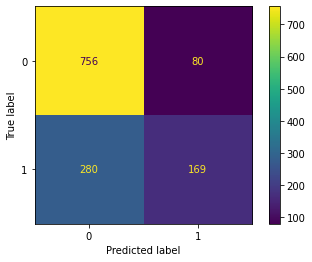

In [9]:
# looking at the confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()